In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.stats import skew, kurtosis
from scipy.ndimage.filters import gaussian_filter
from scipy.stats import linregress
from scipy.optimize import curve_fit
from sklearn.neighbors import KernelDensity

from data_manager import DataManager
import transport_signal_processing as tsp

In [2]:
import matplotlib

font = {'family': 'Arial',
        'size': 16}
matplotlib.rc('font', **font)

In [3]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:77% !important; }</style>"))

## Load data

In [4]:
# parameters
path = "K238A_20C_*0mV_*Oxytocin*"

key_sel = "voltage"
re_sel = ""
#key_sel = "temperature"
level = 1
selected_only = True

# setup database connector
sigman = DataManager('database')

# load segments informations
sinfo_l = sigman.load_info(path, 's*')

# convert info to dataframe
df = pd.DataFrame(sinfo_l)

# keep only key in dataframe and signal info
df = df[df[key_sel].str.match(re_sel) & (df['selected'] > (level-1))]
sinfo_l = [sinfo_l[i] for i in df.index.values]
df = df.reset_index(drop=True)

# set unique instance id
df['iid'] = np.unique(df[key_sel], return_inverse=True)[1]

# debug print
key_sels = np.unique(df[key_sel].values)
key_sels

array(['100', '110', '130', '140', '90'], dtype=object)

In [5]:
# load statistics of all events
ids = []
stats = []
for i in range(len(sinfo_l)):
    sinfo = sinfo_l[i]
    curr_path = sigman.define_db_path(sinfo)
    
    s_l = sigman.load_data(curr_path, 's{}-stats'.format(sinfo['sid']))
    if len(s_l) > 0:
        s = s_l[0]
        m = sigman.load_data(curr_path, 's{}-selected'.format(sinfo['sid']))[0].astype(bool)
        if selected_only:
            s = s[m]

        ids.append(df['iid'].values[i] * np.ones(s.shape[0], dtype=int))
        # rescale mean and standard deviation based on open pore stats
        s[:,1] = 100.0 * s[:,1] / sinfo['mI_open']
        s[:,2] = s[:,2] / sinfo['sI_open']
        #s[:,2] = 100.0 * s[:,2] / sinfo['mI_open']
        stats.append(s)
        
ids_stats = np.concatenate(ids)
stats = np.concatenate(stats)

# rescale dwell time s -> ms
stats[:,0] = stats[:,0] * 1e3

# load find reduced stats for each selected cases
stats_dict = {}
for pn in key_sels:
    df_pn = df[df[key_sel] == pn]
    
    m = np.zeros(ids_stats.shape, dtype=bool)
    for i in np.unique(df_pn['iid']):
        if i in ids_stats:
            m = (m | (ids_stats == i))
    
    stats_dict[pn] = stats[m]

# debug print
print(ids_stats.shape)
print(stats.shape)

(12333,)
(12333, 5)


In [6]:
# parameters
dwt_lim = (0.1, 1000.0)
mI_lim = (0.0, 95.0)

# for all selected key
for pn in key_sels:
    # dwt mask
    m_dwt = (stats_dict[pn][:,0] >= dwt_lim[0]) & (stats_dict[pn][:,0] <= dwt_lim[1])
    # mI mask
    m_mI = (stats_dict[pn][:,1] >= mI_lim[0]) & (stats_dict[pn][:,1] <= mI_lim[1])
    # mask
    m = m_dwt & m_mI
    
    # filter data
    stats_dict[pn] = stats_dict[pn][m]

## Contour plot

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


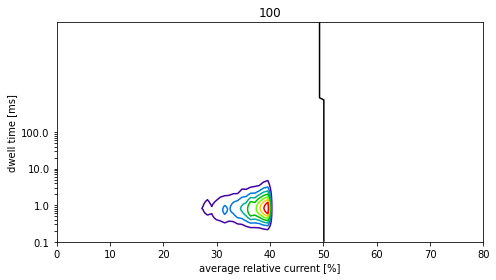

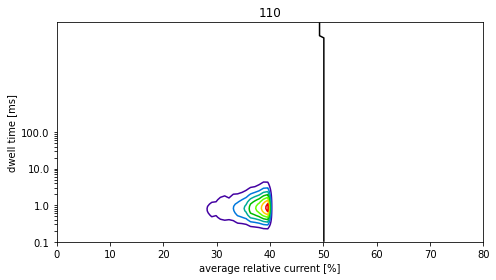

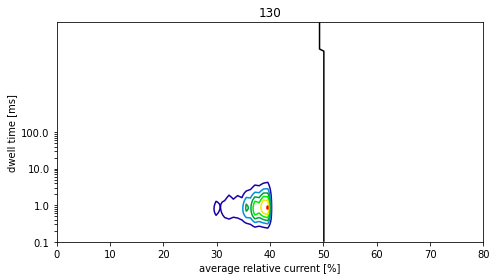

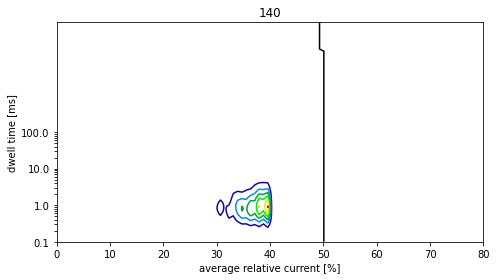

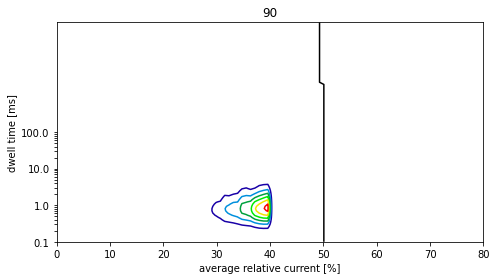

,0,100,110,130,140,90
0,Mean average relative current,30.786734,31.462850,32.449256,32.078564,30.793450
1,Std average relative current,10.240730,9.706248,8.604695,9.041985,10.044006
2,Mean dwell time,0.114813,0.182889,0.285294,0.376127,0.086152
3,Std dwell time,0.558684,0.653475,0.754818,0.808865,0.519290


In [7]:
#### parameters
N = (100,100)
#xlim = (2.5, 22.5)
xlim = (0, 80)
ylim = (np.log10(0.1), np.log10(100000))

table = ['Mean average relative current','Std average relative current','Mean dwell time','Std dwell time']
tb = pd.DataFrame(table)
for pn in key_sels:
    # setup data
    x = stats_dict[pn][:,1].copy()
    y = np.log10(stats_dict[pn][:,0].copy())
    X = np.stack([x,y], axis=1)
    
    # kde
    kde = KernelDensity(bandwidth=0.25)
    kde.fit(X)
    
    # meshgrid
    xi = np.linspace(xlim[0], xlim[1], N[0])
    yi = np.linspace(ylim[0], ylim[1], N[1])
    Xi, Yi = np.meshgrid(xi, yi, indexing='ij')
    
    # apply kde
    Z = np.exp(kde.score_samples(np.stack([Xi.ravel(), Yi.ravel()], axis=1)).reshape(N))
    
    # make log ticks
    yticks = np.concatenate([np.linspace(0.1, 1.0, 10), np.linspace(2.0, 10.0, 9), np.linspace(20.0, 100.0, 9)])
    yticks_labels = []
    for t in yticks:
        if t in [0.1, 1.0, 10.0, 100.0]:
            yticks_labels.append(str(t))
        else:
            yticks_labels.append('')
            
    # plot
    plt.figure(figsize=(7,4))
    plt.contour(Xi, Yi, Z*x.shape[0], 7, cmap='nipy_spectral')
    #plt.contourf(Xi, Yi, Z*x.shape[0], 33, cmap='gist_earth_r')
    plt.yticks(np.log10(yticks), yticks_labels)
    #plt.colorbar()
    plt.ylim(ylim)
    plt.ylabel('dwell time [ms]')
    plt.xlabel('average relative current [%]')
    plt.title(pn)
    plt.tight_layout()
    #plt.savefig('graphs/{}_contour.pdf'.format(pn), dpi=300)
    #plt.savefig('graphs/company-o/{}_contour.pdf'.format(pn), dpi=300)
    plt.show()
    
    # pack data
    tb[pn] = [np.mean(x),np.std(x),np.mean(y),np.std(y)]
    #table = {
    #f"mean average relative current = {np.mean(x):.2f}",
    #f"std average relative current = {np.std(x):.2f}",
    #f"mean dwell time = {np.mean(y):.2f}",
    #f"std dwell time = {np.std(y):.2f}"
    #      }
    pass
pass
    # create dataframe
    #tb = pd.DataFrame(table)
    
    # debug display
display(tb)

In [8]:
# parameters
sampling_size = 50
num_resampling = 10000

# for all selected keys
ampl_data = {}
for pn in key_sels:
    # storage
    mX_ampl = np.zeros((num_resampling,2))
    
    # extract data
    x = stats_dict[pn][:,1].copy()
    y = np.log10(stats_dict[pn][:,0].copy())
    X = np.stack([x,y], axis=1)
    ids = np.arange(X.shape[0])
    
    for i in tqdm(range(num_resampling)):
        ids_smpl = np.random.choice(ids, sampling_size, replace=False)
        mX_ampl[i] = np.mean(X[ids_smpl], axis=0)
    
    # store results
    ampl_data[pn] = mX_ampl.copy()

100%|██████████| 10000/10000 [00:00<00:00, 17222.86it/s]


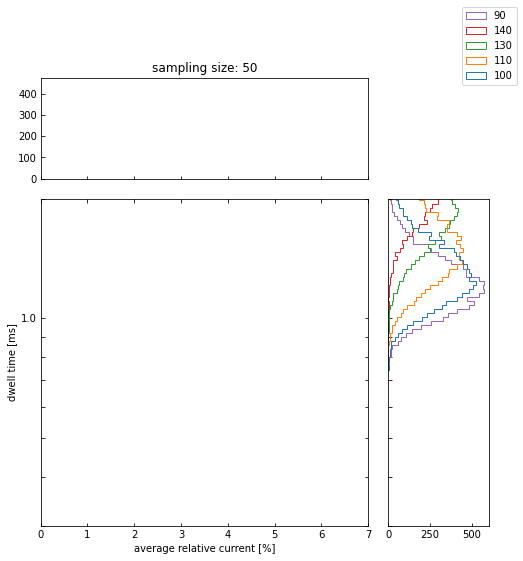

In [10]:
# parameters
xlim = (0, 7)
#xlim = (2.5, 22.5)
ylim = (np.log10(0.3), np.log10(2))
bins = 100

sampling_size

# plot parameters
left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
spacing = 0.005*8

# start with a rectangular Figure
plt.figure(figsize=(7, 7))

# figure setup
rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom + height + spacing, width, 0.2]
rect_histy = [left + width + spacing, bottom, 0.2, height]

ax_scatter = plt.axes(rect_scatter)
ax_scatter.set_yticks(np.log10(yticks))
ax_scatter.set_yticklabels(yticks_labels)
ax_scatter.tick_params(direction='in', top=True, right=True)
ax_scatter.set_xlabel('average relative current [%]')
ax_scatter.set_ylabel('dwell time [ms]')
ax_histx = plt.axes(rect_histx)
ax_histx.tick_params(direction='in', labelbottom=False)
ax_histy = plt.axes(rect_histy)
ax_histy.set_yticks(np.log10(yticks))
ax_histy.set_yticklabels(yticks_labels)
ax_histy.tick_params(direction='in', labelleft=False)

# make log ticks
yticks = np.concatenate([np.linspace(0.1, 1.0, 10), np.linspace(2.0, 10.0, 9), np.linspace(20.0, 100.0, 9), np.linspace(200.0, 1000.0, 9), np.linspace(2000.0, 10000.0, 9)])
#yticks = np.concatenate([np.linspace(0.1, 1.0, 10), np.linspace(2.0, 10.0, 9), np.linspace(20.0, 100.0, 9), np.linspace(200.0, 1000.0, 9)])
yticks_labels = []
for t in yticks:
    if t in [0.1, 1.0, 10.0, 100.0, 1000.0, 10000.0, 100000.0]:
        yticks_labels.append(str(t))
    else:
        yticks_labels.append('')

# scatter plot
for pn in key_sels:
    X = ampl_data[pn].copy()    
    ax_scatter.plot(X[:,0], X[:,1], '.', label=pn, alpha=1.0, ms=1.0)
    #ax_scatter.errorbar(np.mean(X[:,0]), np.mean(X[:,1]), xerr=np.std(X[:,0]), yerr=np.std(X[:,1]), fmt='k', label=pn, alpha=1.0)
    
ax_scatter.set_yticks(np.log10(yticks), yticks_labels)
ax_scatter.set_xlim(xlim)
ax_scatter.set_ylim(ylim)

ax_histx.hist([ampl_data[pn][:,0] for pn in ampl_data], bins=bins, histtype='step')
ax_histy.hist([ampl_data[pn][:,1] for pn in ampl_data], bins=bins, histtype='step', orientation='horizontal', label=list(ampl_data))

ax_histx.set_xlim(ax_scatter.get_xlim())
ax_histy.set_ylim(ax_scatter.get_ylim())

ax_histy.legend(loc='upper center', bbox_to_anchor=(1.0, 1.6))
ax_histx.set_title("sampling size: {}".format(sampling_size))

#plt.savefig('graphs/C20-azide_K238A_Urea/8MUrea3MKCl_cores-disabled_voltagedependency_N{}.png'.format(sampling_size), dpi=150, bbox_inches='tight')

plt.show()

### Points cloud

### Current distribution fit gaussian fit

In [ ]:
def gauss(x, A, mu, sigma):
    return np.abs(A) * np.exp(-np.square((x - mu))/np.square(sigma))
    
def bimodal_gauss(x, A0, mu0, sigma0, A1, mu1, sigma1):
    return gauss(x, A0, mu0, sigma0) + gauss(x, A1, mu1, sigma1)
    
def bimodal_gauss_fitting(I, bandwidth=1.0, N=100):  
    # KDE
    kde = KernelDensity(bandwidth=bandwidth)
    kde.fit(I.reshape(-1,1))

    x = np.linspace(np.min(I), np.max(I), N)
    y = np.exp(kde.score_samples(x.reshape(-1,1))).ravel()
    
    # create guess for fit
    guess = np.array([np.max(y), x[np.argmax(y)]*0.97, 1.0, np.max(y), x[np.argmax(y)]*1.03, 1.0])

    # perform multi gauss fit
    popt, pcov = curve_fit(bimodal_gauss, x.astype(np.float64), y.astype(np.float64), p0=guess.astype(np.float64))

    # compute gaussian functions
    z = gauss(x, popt[0], popt[1], popt[2])
    
    popt_l = [popt[0:3], popt[3:6]]

    return popt_l, x, y, z

def plot_gaussian_dist_fit(x, y, popt):
    plt.plot(x, y)
    plt.plot(x, gauss(x, popt[0], popt[1], popt[2]))
    plt.xlabel('current [pA]')
    plt.ylabel('density')

In [ ]:
# parameters
xlim = (40.0, 95.0)

for pn in key_sels:
    # extract stats
    dwt = stats_dict[pn][:,0].copy()
    mI = stats_dict[pn][:,1].copy()
    
    # gaussian fit
    #popt_l, x, y = tsp.multi_gauss_decomposition(mI, thr=0.1, res=0.5, N_lim=5)
    popt_l, x, d, y = bimodal_gauss_fitting(mI, bandwidth=0.5, N=100)

    # plot
    plt.figure(figsize=(7,4))
    plt.hist(mI, bins=40, range=xlim, density=True, histtype='step')

    #plt.plot(x, y)
    s = np.zeros(x.shape)
    for popt in popt_l:
        dp = gauss(x, popt[0], popt[1], popt[2])
        s += dp
        plt.plot(x, dp, label="μ={:.1f}, σ={:.1f}".format(popt[1], popt[2]))
        
    #plt.plot(x, s, label='sum fits')
    plt.plot(x, d, 'k', label='kde')
    plt.fill_between(x, s, d, color='k', alpha=0.25, label='error')
    plt.xlim(xlim)

    plt.legend(loc='best')
    plt.xlabel('average relative current [%]')
    plt.ylabel('density')
    plt.title(pn)
    plt.tight_layout()
    #plt.savefig('graphs/{}_average_relative_current_distribution_with_fit.pdf'.format(pn), dpi=300)
    #plt.savefig('graphs/{}_average_relative_current_distribution_with_fit.png'.format(pn), dpi=300)
    plt.show()

### Dwell time fit

In [ ]:
from scipy.special import gamma

def exp_pdf(x, s, a):
    return s * a * np.exp(-a * x)


def dwt_exp_fit(dwts, rb, rs, xr):
    # kde estimation of dwell time log distribution
    kde = KernelDensity(bandwidth=rb)
    kde.fit(dwts.reshape(-1,1))
    x = np.linspace(xr[0], xr[1], int((xr[1]-xr[0])/rs))
    y = kde.score_samples(x.reshape(-1,1))

    # exp fit
    popt, pcov = curve_fit(exp_pdf, x, np.exp(y), [1.0, 1.0])

    # pack fit data
    dfit = (x,np.exp(y),x,exp_pdf(x, *popt))

    # return data
    return 1.0/popt[1], np.sqrt(pcov[1][1])/np.square(popt[1]), dfit


def gamma_pdf(x, s, a, b):
    return s * np.power(x, a-1.0) * np.exp(-b * x) * np.power(b, a) / gamma(a)


def dwt_gamma_fit(dwts, rb, rs, xr):
    # kde estimation of dwell time log distribution
    kde = KernelDensity(bandwidth=rb)
    kde.fit(dwts.reshape(-1,1))
    x = np.linspace(xr[0], xr[1], int((xr[1]-xr[0])/rs))
    y = kde.score_samples(x.reshape(-1,1))

    # exp fit
    popt, pcov = curve_fit(gamma_pdf, x, np.exp(y), [1.0, 1.5, 1.5])

    # pack fit data
    dfit = (x,np.exp(y),x,gamma_pdf(x, *popt))

    # expectation value
    mdwt = popt[1] / popt[2]

    sdwt = np.sqrt(pcov[1][1])/popt[2] + popt[1]*np.sqrt(pcov[2][2])/np.square(popt[2])

    # return data
    return mdwt, sdwt, dfit

In [ ]:
# parameters
rb = 0.2
rs_l = [0.2]
xr_l = [(0.6, 6.0)]
xlim_l = [(0.2,10)]

#rs_l = [0.2, 0.1, 0.1, 0.1, 0.1, 0.1, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2]
#xr_l = [(0.5, 17.0), (0.5, 5.0), (0.5, 5.0), (0.5, 5.0), (0.5, 5.0), (0.5, 7.0), (0.5, 10.0), (0.5, 20.0), (0.5, 20.0), (0.5, 20.0), (0.5, 20.0), (0.5, 20.0), (0.5, 20.0), (2, 50.0), (1, 20.0), (1, 20.0), (0.5, 20.0), (0.5, 20.0), (0.5, 20.0)]
#xlim_l = [(0.4, 17.0), (0.2, 5.0), (0.2, 5.0), (0.2, 5.0), (0.2, 5.0), (0.2, 7.0), (0.2, 10.0), (0.2, 20.0), (0.2, 20.0), (0.2, 20.0), (0.2, 20.0), (0.2, 20.0), (0.2, 20.0), (2, 50.0), (0.2, 20.0), (0.2, 20.0), (0.2, 20.0), (0.2, 20.0), (0.2, 20.0)]
#rs_l = [0.5, 0.5, 0.5, 0.5, 0.1, 0.1, 0.5]
#xr_l = [(1.5, 20.0), (1.5, 20.0), (1.5, 20.0), (1.5, 20.0), (0.4, 10.0), (0.4, 10.0), (1.5, 20.0)]
#xlim_l = [(1.5, 20.0), (1.5, 20.0), (1.5, 20.0), (1.5, 20.0), (0.4, 10.0), (0.4, 10.0), (1.5, 20.0)]

#rs_l = [0.1, 0.5, 0.1, 0.1, 0.1, 0.1, 0.1]
#xr_l = [(1.7, 20.0), (1.0, 30), (2.0, 30.0), (1.9, 15.0), (1.0, 20.0), (0.55, 10.0), (0.4, 4.0)]
#xlim_l = [(1.6, 12.0), (0.65, 20), (2.0, 25.0), (1.9, 15.0), (1.0, 20.0), (0.48, 4.0), (0.35, 4.0)]

for i, pn in enumerate(key_sels):
    # get parameters
    xr = xr_l[0]
    xlim = xlim_l[0]
    rs = rs_l[0]
    
    # get data
    dwt = stats_dict[pn][:,0].copy()
    
    # fit durations
    t_fit, st_fit, fit_data = dwt_exp_fit(dwt, rb, rs, xr)
    #t_fit, st_fit, fit_data = dwt_gamma_fit(dwt, rb, rs, xr)
    # unpack fitted data
    x,y,x_fit,y_fit = fit_data
    
    # plot
    plt.figure(figsize=(7,4))
    plt.bar(x, y*rb*len(dwt), rs*1.1)
    plt.plot(x_fit, y_fit*rb*len(dwt), '-', color=(0.23,0.23,0.23), label='{:.2f} ± {:.2f}ms'.format(t_fit, max(st_fit,0.01)))
    plt.legend(loc='best')
    print(np.min(y))
    plt.xlim(xlim)
    plt.ylabel('count')
    plt.xlabel('dwell time [ms]')
    plt.title(pn)
    plt.tight_layout()
    #plt.savefig('graphs/{}_dwell_time_distribution_with_fit.pdf'.format(pn), dpi=300)
    #plt.savefig('graphs/{}_dwell_time_distribution_with_fit.png'.format(pn), dpi=300)
    plt.show()